In [2]:
%%capture
!pip install librosa

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
import pandas as pd
import random
from PIL import Image
from IPython.display import display
from scipy.signal import butter, lfilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset_path = "data"

classes = os.listdir(dataset_path)
classes

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero',
 '_background_noise_']

In [6]:
file_count = {}
for class_name in classes:
    file_count[class_name] = len(os.listdir(os.path.join(dataset_path, class_name)))

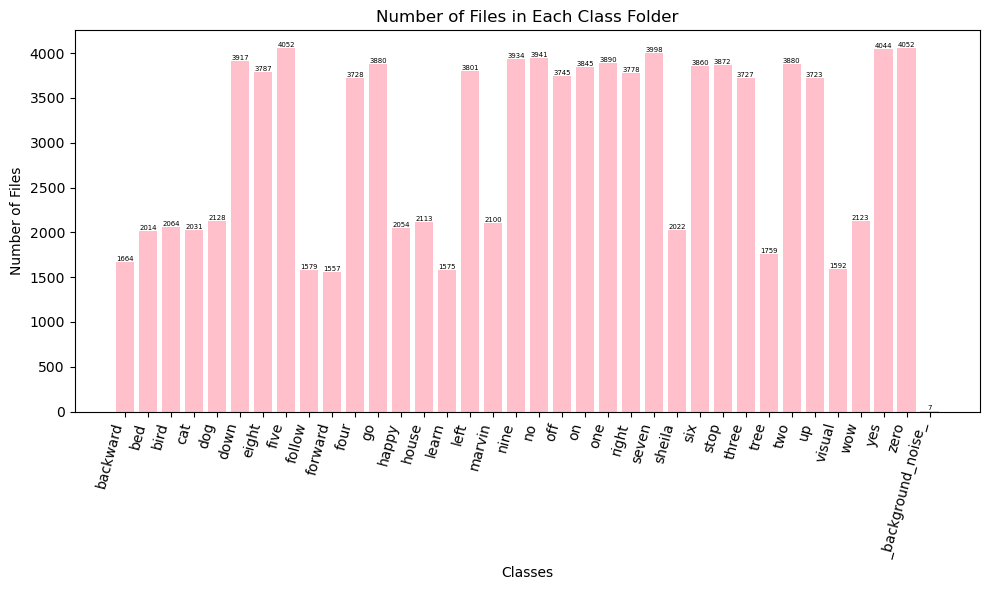

In [7]:
plt.figure(figsize=(10, 6))
bars = plt.bar(file_count.keys(), file_count.values(), color='pink')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=5)

plt.xticks(rotation=75, ha='right')
plt.xlabel('Classes')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Class Folder')
plt.tight_layout()
plt.savefig('class_imabalance.png')
plt.show()

In [74]:
# target_size = 15
# audio_data = []
# labels = []
# for class_name in classes:
#     if class_name == '_background_noise_':
#         continue
#     class_path = os.path.join(dataset_path, class_name)
#     audio_files = os.listdir(class_path)
#     downsampled = random.sample(audio_files, target_size)
#     for audio_file in downsampled:
#         audio_path = os.path.join(class_path, audio_file)
#         audio, sr = librosa.load(audio_path, sr=16000)
#         audio_data.append(audio)
#         labels.append(class_name)

# audio_df = pd.DataFrame({
#     'audio_data': audio_data,
#     'label': labels
# })

# print(f"Loaded {len(audio_data)} audio files, with {target_size} from each class.")

audio_data = []
labels = []
for class_name in classes:
    if class_name == '_background_noise_':
        continue
    class_path = os.path.join(dataset_path, class_name)
    audio_files = os.listdir(class_path)
    for audio_file in audio_files:
        audio_path = os.path.join(class_path, audio_file)
        audio, sr = librosa.load(audio_path, sr=16000)
        audio_data.append(audio)
        labels.append(class_name)

audio_df = pd.DataFrame({
    'audio_data': audio_data,
    'label': labels
})
print(audio_df.shape)

(105829, 2)


In [75]:
audio_df.head()

,audio_data,label
0,"[-0.06576538, -0.07092285, -0.07531738, -0.079...",backward
1,"[-0.0002746582, -0.00021362305, -0.00045776367...",backward
2,"[-6.1035156e-05, -0.00018310547, -0.0002441406...",backward
3,"[9.1552734e-05, 0.00024414062, 0.00024414062, ...",backward
4,"[0.0, -9.1552734e-05, -0.00024414062, -0.00024...",backward


#### 1. Perform extensive exploratory data analysis (EDA) by performing the below-given sub-tasks:

##### a. Find the statistical summary of the amplitude values and duration distribution of the audio files for each class. Write your observations.

References:
- [AskPython: Amplitude of .wav files](https://www.askpython.com/python/examples/amplitude-of-wav-files)

- [Librosa Documentation](https://librosa.org/doc/main/generated/librosa.get_duration.html)

In [76]:
sample_rate = 16000
audio_df['duration'] = audio_df['audio_data'].apply(lambda x: len(x) / sample_rate)
audio_df.head()

,audio_data,label,duration
0,"[-0.06576538, -0.07092285, -0.07531738, -0.079...",backward,1.0
1,"[-0.0002746582, -0.00021362305, -0.00045776367...",backward,1.0
2,"[-6.1035156e-05, -0.00018310547, -0.0002441406...",backward,1.0
3,"[9.1552734e-05, 0.00024414062, 0.00024414062, ...",backward,1.0
4,"[0.0, -9.1552734e-05, -0.00024414062, -0.00024...",backward,1.0


In [77]:
def amplitude_summary(audio_data):
    minimum = float('inf')
    maximum = float('-inf')
    mean = 0
    std = 0
    total = 0

    for i in audio_data:
        mini = np.min(i)
        maxi = np.max(i)
        if mini < minimum:
            minimum = mini
        if maxi > maximum:
            maximum = maxi
        mean += np.sum(i)
        total += len(i)

    mean /= total

    for i in audio_data:
        std += ((np.array(i) - mean) ** 2).sum()
    std = (std / total) ** 0.5

    return pd.DataFrame({'mean': [mean], 'min': [minimum], 'max': [maximum], 'std': [std]})

In [78]:
amplitude_stats = audio_df.groupby('label')['audio_data'].apply(amplitude_summary)
if isinstance(amplitude_stats, pd.Series):
    amplitude_stats = amplitude_stats.reset_index()
amplitude_stats.index = amplitude_stats.index.map(lambda x: x[0])
amplitude_stats.columns = ['mean_amplitude', 'min_amplitude', 'max_amplitude', 'std_amplitude']
duration_stats = audio_df.groupby('label')['duration'].agg(['mean', 'min', 'max', 'std'])
duration_stats.columns = ['mean_duration', 'min_duration', 'max_duration', 'std_duration']
summary_df = pd.concat([amplitude_stats, duration_stats], axis=1)
summary_df

,mean_amplitude,min_amplitude,max_amplitude,std_amplitude,mean_duration,min_duration,max_duration,std_duration
backward,8.732750e-05,-1.0,0.999969,0.088580,0.986390,0.448000,1.0,0.062522
bed,6.745070e-05,-1.0,0.999969,0.085238,0.970498,0.213312,1.0,0.087145
bird,-1.830991e-04,-1.0,0.999969,0.095966,0.969454,0.325062,1.0,0.092588
cat,-2.848711e-04,-1.0,0.999969,0.075283,0.972065,0.384000,1.0,0.082372
dog,-4.608297e-04,-1.0,0.999969,0.093553,0.972226,0.426625,1.0,0.084865
down,4.458849e-05,-1.0,0.999969,0.087863,0.983559,0.325062,1.0,0.067175
eight,-2.228617e-05,-1.0,0.999969,0.076257,0.980846,0.256000,1.0,0.072684
five,1.695451e-05,-1.0,0.999969,0.092054,0.984320,0.384000,1.0,0.065863
follow,-1.721267e-04,-1.0,0.999969,0.103674,0.981981,0.341313,1.0,0.074247
forward,8.766092e-05,-1.0,0.999969,0.107183,0.984746,0.384000,1.0,0.066149


##### b. Plot graphical representations such as waveform plots, spectrograms, Melspectrograms, etc for randomly selected 3 audio files from randomly selected 3 classes out of 35 classes. Write your observations.

References:

- [Librosa: MelSpectogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html)

- [Librosa: Waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)

- [Librosa: Spectogram](https://librosa.org/doc/main/auto_examples/plot_display.html)

In [79]:
def get_waveform_by_class(class_audio_data, class_name):
    fig, ax = plt.subplots(1, len(class_audio_data), figsize=(10, 3))

    for i, audio_data in enumerate(class_audio_data):
        librosa.display.waveshow(audio_data, sr=16000, ax=ax[i])
        ax[i].set_title(f'Waveform of {class_name} file {i + 1}')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

In [80]:
def get_spectogram_by_class(class_audio_data, class_name):
    plt.figure(figsize=(10, 3))

    for i, audio_data in enumerate(class_audio_data):
        D = librosa.stft(audio_data)
        plt.subplot(1, len(class_audio_data), i + 1)
        S = librosa.feature.melspectrogram(S=D, sr=16000)
        plt.subplot(1, len(class_audio_data), i + 1)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=16000, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectogram of {class_name} file {i+1}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

In [81]:
def get_melspectogram_by_class(class_audio_data, class_name):
    fig, ax = plt.subplots(1, len(class_audio_data), figsize=(10, 3))

    for i, audio_data in enumerate(class_audio_data):
        D = np.abs(librosa.stft(audio_data))**2
        S = librosa.feature.melspectrogram(S=D, sr=16000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',
                                y_axis='mel', sr=16000,
                                fmax=8000, ax=ax[i])
        fig.colorbar(img, ax=ax[i], format='%+2.0f dB')
        ax[i].set_title(f'Melspectogram of {class_name} file {i+1}')
        ax[i].set_xlabel('Time (s)')
        ax[i].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

In [82]:
random_class = random.sample(list(audio_df['label'].unique()), 3)
random_audio = {}
for class_name in random_class:
    class_file = audio_df[audio_df['label'] == class_name]['audio_data'].tolist()
    random_audio[class_name] = random.sample(class_file, 3)

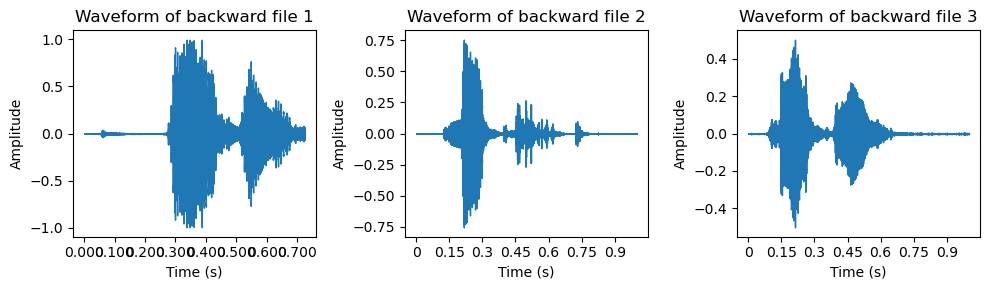

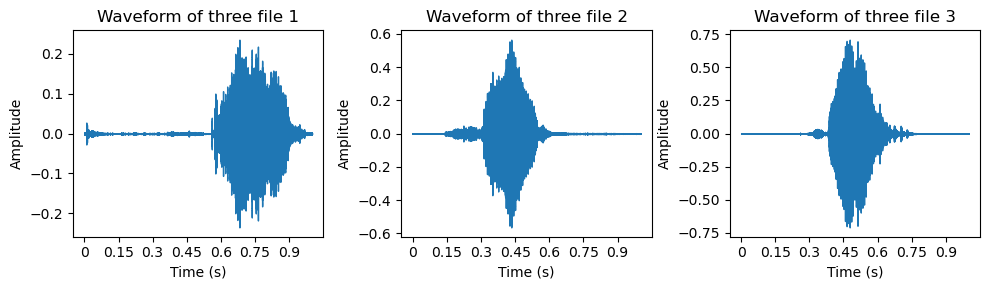

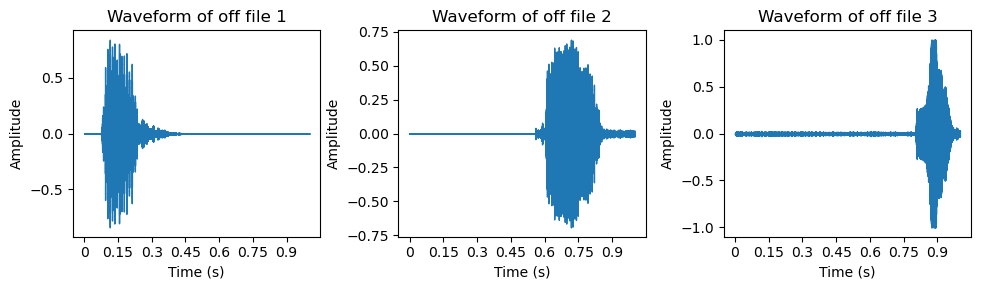

In [83]:
for class_name, class_file in random_audio.items():
    get_waveform_by_class(class_file, class_name)

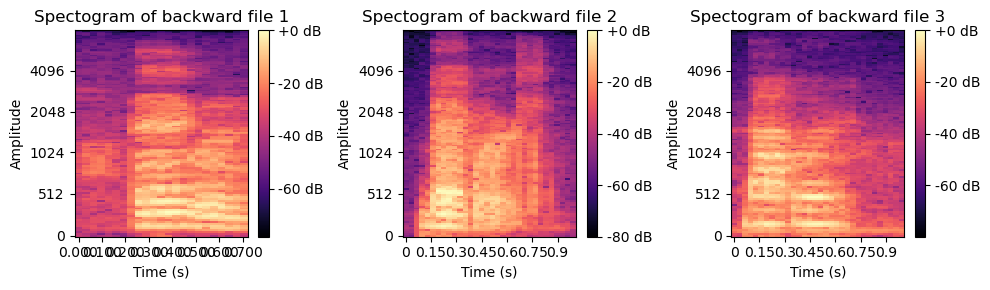

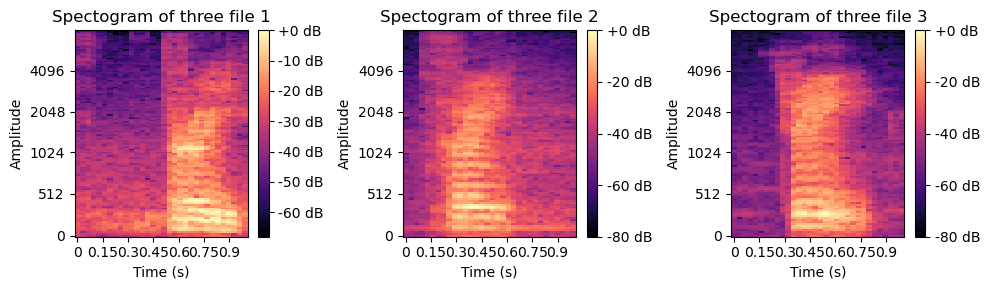

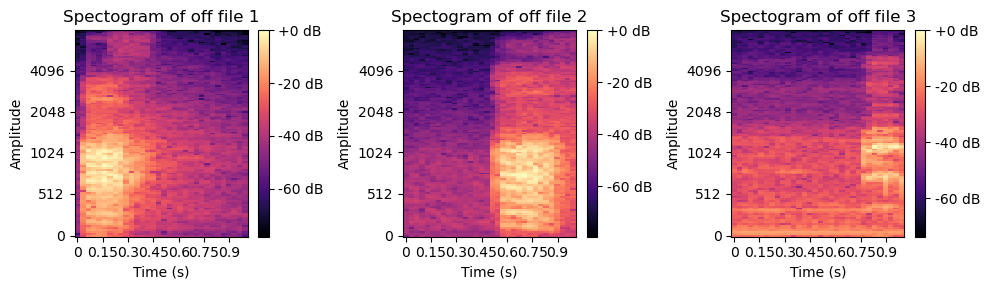

In [84]:
for class_name, class_file in random_audio.items():
    get_spectogram_by_class(class_file, class_name)

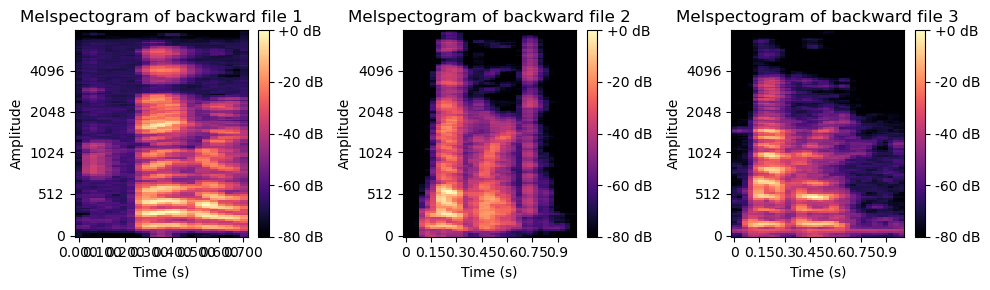

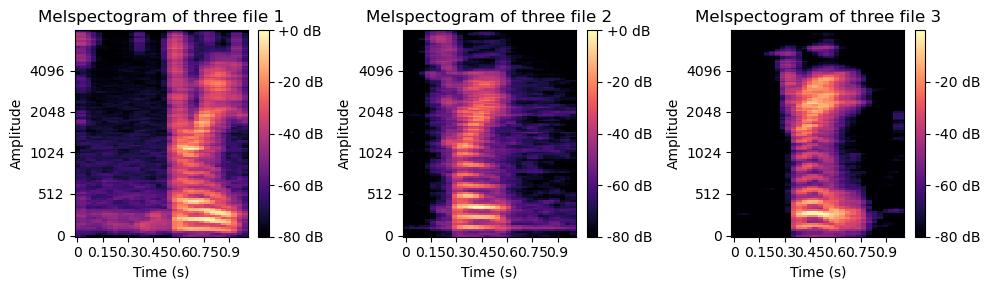

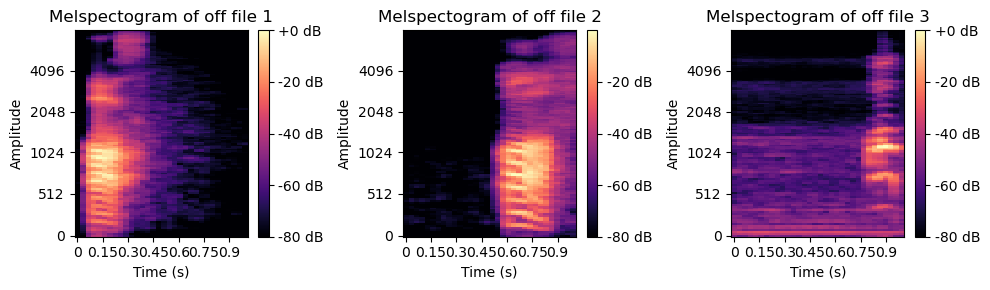

In [85]:
for class_name, class_file in random_audio.items():
    get_melspectogram_by_class(class_file, class_name)

##### c.  Investigate any class imbalances in the dataset, and if present, handle them through techniques like oversampling, undersampling, or data augmentation.

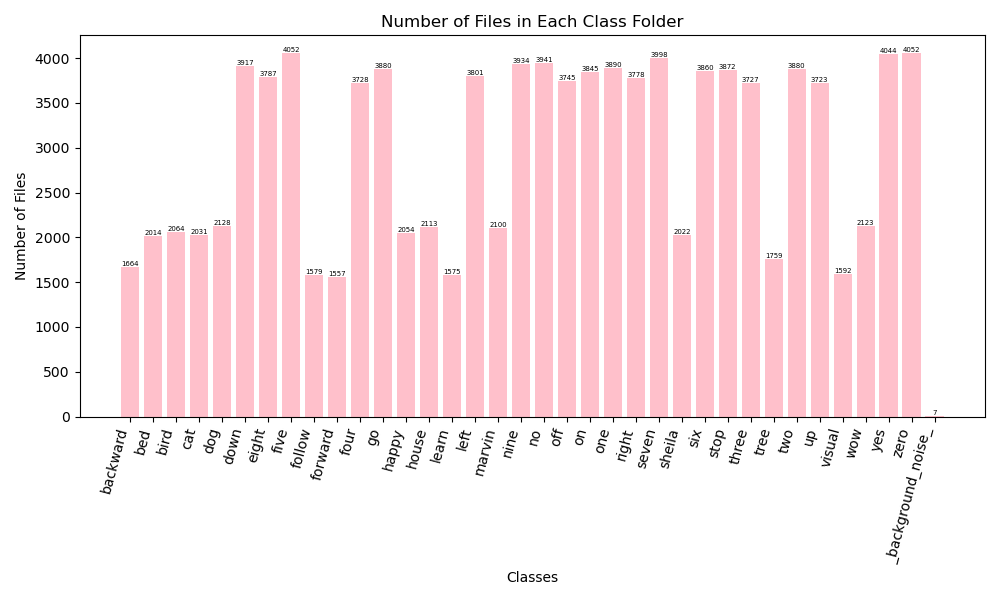

In [86]:
img = Image.open("class_imabalance.png")
display(img)

Since we notice class imbalance, we select a minimum threshold to filter out from the classes. In this case, we select 1550 as the minimum number and hence, we downsample the dataset to 1550 images per classes. We ignore the `_background_noise_` for this purpose.

In [87]:
target_samples = 1550

audio_df_downsampled = (
    audio_df.groupby('label')
           .sample(n=target_samples, replace=False, random_state=42)
)

audio_df_downsampled.reset_index(drop=True, inplace=True)
print(audio_df_downsampled.shape)

(54250, 3)


In [105]:
audio_df_downsampled.head()

,audio_data,label,duration
0,"[-0.0027160645, -0.0020141602, -0.00076293945,...",backward,1.0
1,"[-0.0021362305, -0.0031433105, 0.0010070801, 0...",backward,1.0
2,"[-3.0517578e-05, -9.1552734e-05, -9.1552734e-0...",backward,1.0
3,"[3.0517578e-05, 3.0517578e-05, 3.0517578e-05, ...",backward,1.0
4,"[-6.1035156e-05, -6.1035156e-05, -6.1035156e-0...",backward,1.0


##### d. Perform data cleaning by detecting and addressing outliers like silent segments etc.



References:
- [Github: Remove silence](https://github.com/ngbala6/Audio-Processing/blob/master/Silence-Remove/silenceremove.py)

In [106]:
def remove_silence(audio_data, sample_rate=16000, frame_size=1024, threshold=0.01):
    num_frames = int(len(audio_data) / frame_size)
    frame_energy = np.array([np.sum(audio_data[i * frame_size : (i + 1) * frame_size] ** 2) for i in range(num_frames)])
    frame_energy = frame_energy / np.max(frame_energy)
    non_silent_frames = frame_energy > threshold
    non_silent_audio = np.concatenate([audio_data[i * frame_size : (i + 1) * frame_size] for i in range(num_frames) if non_silent_frames[i]])
    return non_silent_audio

In [107]:
cleaned_df = audio_df_downsampled.copy()
cleaned_df['audio_data'] = audio_df_downsampled['audio_data'].apply(remove_silence)
cleaned_df['duration'] = cleaned_df['audio_data'].apply(lambda x: len(x) / sample_rate)
cleaned_df.head()

,audio_data,label,duration
0,"[-0.0014038086, -0.0017089844, -0.001953125, -...",backward,0.448
1,"[-0.0024414062, -0.0014648438, -0.0030822754, ...",backward,0.704
2,"[3.0517578e-05, 6.1035156e-05, 6.1035156e-05, ...",backward,0.384
3,"[-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...",backward,0.448
4,"[-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...",backward,0.320


In [108]:
random_class = random.sample(list(audio_df_downsampled['label'].unique()), 3)
random_audio = {}
for class_name in random_class:
    class_file = cleaned_df[cleaned_df['label'] == class_name]['audio_data'].tolist()
    random_audio[class_name] = random.sample(class_file, 3)

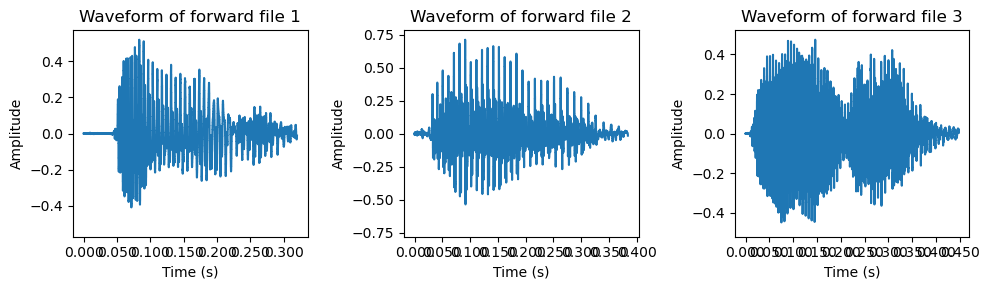

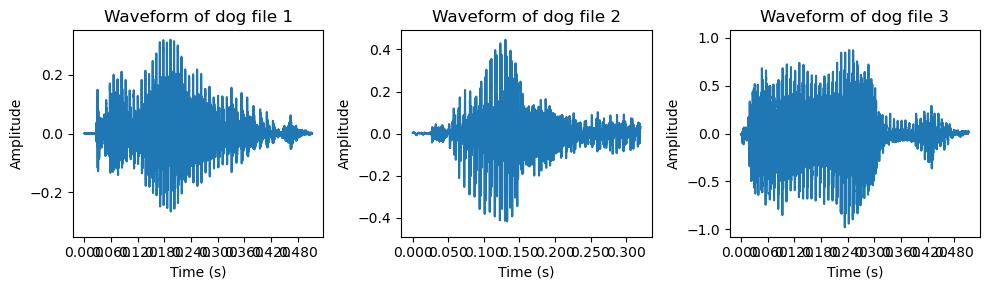

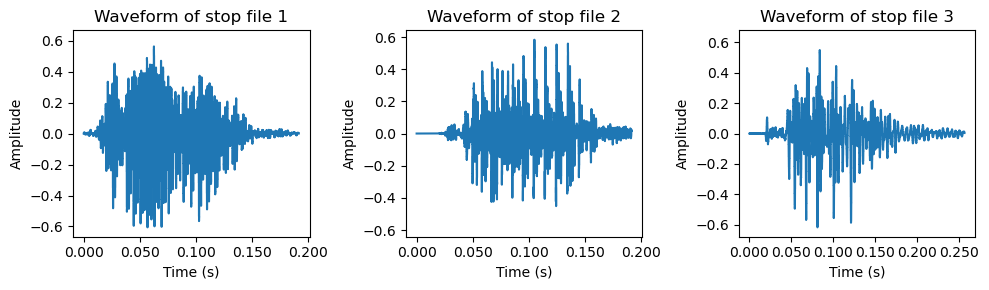

In [109]:
for class_name, class_file in random_audio.items():
    get_waveform_by_class(class_file, class_name)

We notice that there are no silent segments remaining anymore in our audio waveform. Hence, we have successfully remove silence outliers.

#### 2. Perform Feature Extraction: Extract relevant features from the audio data, such as MFCCs, chroma features, spectral features, and features extracted using filters like bandpass filter, etc.

In [110]:
cleaned_df.head()

,audio_data,label,duration
0,"[-0.0014038086, -0.0017089844, -0.001953125, -...",backward,0.448
1,"[-0.0024414062, -0.0014648438, -0.0030822754, ...",backward,0.704
2,"[3.0517578e-05, 6.1035156e-05, 6.1035156e-05, ...",backward,0.384
3,"[-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...",backward,0.448
4,"[-3.0517578e-05, -3.0517578e-05, -6.1035156e-0...",backward,0.320


References:

- [Hacker's Realm: MFCC Feature Extraction](https://www.hackersrealm.net/post/extract-features-from-audio-mfcc-python)

- [Towards Data Science: Music Feature Extraction](https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d)

- [DSP StackExchange: Bandpass Filter](https://dsp.stackexchange.com/questions/56604/bandpass-filter-for-audio-wav-file)

In [111]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def extract_features(audio_data, sample_rate):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=16000, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=16000)
    chroma_mean = np.mean(chroma.T, axis=0)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=16000)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=16000)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    filtered_audio = bandpass_filter(audio_data, lowcut=300, highcut=3400, fs=8000, order=6)
    rms = librosa.feature.rms(y=filtered_audio)
    rms_mean = np.mean(rms)
    features = {
        'mfccs_mean': mfccs_mean,
        'chroma_mean': chroma_mean,
        'spectral_centroid_mean': spectral_centroid_mean,
        'spectral_bandwidth_mean': spectral_bandwidth_mean,
        'zero_crossing_rate_mean': zero_crossing_rate_mean,
        'spectral_rolloff_mean': spectral_rolloff_mean,
        'rms_mean': rms_mean
    }
    return features

In [112]:
extracted_features = cleaned_df.apply(lambda row: pd.Series(extract_features(row['audio_data'], 16000)), axis=1)

In [113]:
array_lengths = extracted_features['mfccs_mean'].apply(lambda x: len(x) if isinstance(x, np.ndarray) else None)

unique_lengths = array_lengths.unique()

if len(unique_lengths) == 1:
    print(f"All arrays have the same length: {unique_lengths[0]}")
else:
    print(f"Array lengths are not the same. Unique lengths: {unique_lengths}")

All arrays have the same length: 13


In [114]:
array_lengths = extracted_features['chroma_mean'].apply(lambda x: len(x) if isinstance(x, np.ndarray) else None)

unique_lengths = array_lengths.unique()

if len(unique_lengths) == 1:
    print(f"All arrays have the same length: {unique_lengths[0]}")
else:
    print(f"Array lengths are not the same. Unique lengths: {unique_lengths}")

All arrays have the same length: 12


In [115]:
mfcc_df = pd.DataFrame(extracted_features['mfccs_mean'].to_list(), columns=[f'mfcc_{i+1}' for i in range(13)])
chroma_df = pd.DataFrame(extracted_features['chroma_mean'].to_list(), columns=[f'chroma_{i+1}' for i in range(12)])

extracted_features.drop(['mfccs_mean', 'chroma_mean'], axis=1, inplace=True)

extracted_features = pd.concat([extracted_features, mfcc_df, chroma_df], axis=1)

final_df = pd.concat([cleaned_df['label'], extracted_features], axis=1)

final_df.head()

,label,spectral_centroid_mean,spectral_bandwidth_mean,zero_crossing_rate_mean,spectral_rolloff_mean,rms_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12
0,backward,767.310122,905.688596,0.051172,1347.916667,0.045046,-251.145157,195.003555,-1.752442,-12.426566,...,0.370842,0.357058,0.412294,0.403232,0.432245,0.525623,0.414770,0.447085,0.403655,0.313435
1,backward,2260.557462,1919.973460,0.193720,4459.578804,0.005423,-289.681580,53.646294,-11.003576,29.635967,...,0.367038,0.395249,0.391226,0.320093,0.275341,0.306995,0.429252,0.516044,0.665863,0.672967
2,backward,1031.844609,1117.649869,0.067045,1770.432692,0.016271,-354.272644,165.083176,-15.887679,0.995974,...,0.487317,0.412426,0.390176,0.650928,0.625157,0.286070,0.189935,0.280087,0.424134,0.381754
3,backward,827.776084,954.454642,0.058171,1370.312500,0.051055,-218.912827,176.962402,-12.354716,2.161292,...,0.479132,0.221494,0.274512,0.457112,0.443343,0.332009,0.400818,0.526767,0.430530,0.229915
4,backward,1015.808774,833.809137,0.083851,1612.926136,0.061569,-232.595505,199.750244,-78.129555,7.370862,...,0.423923,0.330688,0.503765,0.727110,0.428252,0.516891,0.559935,0.387541,0.434654,0.313975


In [116]:
le = LabelEncoder()

final_df['label'] = le.fit_transform(final_df['label'])
final_df.head()

,label,spectral_centroid_mean,spectral_bandwidth_mean,zero_crossing_rate_mean,spectral_rolloff_mean,rms_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12
0,0,767.310122,905.688596,0.051172,1347.916667,0.045046,-251.145157,195.003555,-1.752442,-12.426566,...,0.370842,0.357058,0.412294,0.403232,0.432245,0.525623,0.414770,0.447085,0.403655,0.313435
1,0,2260.557462,1919.973460,0.193720,4459.578804,0.005423,-289.681580,53.646294,-11.003576,29.635967,...,0.367038,0.395249,0.391226,0.320093,0.275341,0.306995,0.429252,0.516044,0.665863,0.672967
2,0,1031.844609,1117.649869,0.067045,1770.432692,0.016271,-354.272644,165.083176,-15.887679,0.995974,...,0.487317,0.412426,0.390176,0.650928,0.625157,0.286070,0.189935,0.280087,0.424134,0.381754
3,0,827.776084,954.454642,0.058171,1370.312500,0.051055,-218.912827,176.962402,-12.354716,2.161292,...,0.479132,0.221494,0.274512,0.457112,0.443343,0.332009,0.400818,0.526767,0.430530,0.229915
4,0,1015.808774,833.809137,0.083851,1612.926136,0.061569,-232.595505,199.750244,-78.129555,7.370862,...,0.423923,0.330688,0.503765,0.727110,0.428252,0.516891,0.559935,0.387541,0.434654,0.313975


In [117]:
final_df.to_csv('extracted_df.csv', index = False)

In [118]:
final_df.shape

(54250, 31)

# 3. Model Selection and Implementation:

##### a. You are allowed to use only any one or ensemble of Naive Bayes, Decision Tree, Random Forest, and Perceptron models, all implemented from scratch. Train and test these models on the prepared dataset using an 80:20 train-test split.

In [4]:
final_df = pd.read_csv('extracted_df.csv')

In [5]:
X = final_df.drop(columns=['label'])
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"The training set size is {X_train.shape}")
print(f"The testing set size is {X_test.shape}")

The training set size is (43400, 30)
The testing set size is (10850, 30)


In [120]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [121]:
print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

   spectral_centroid_mean  spectral_bandwidth_mean  zero_crossing_rate_mean  \
0                0.147073                 0.297385                 0.074104   
1                0.099121                 0.270122                 0.090660   
2                0.095951                 0.258737                 0.085404   
3                0.171073                 0.442623                 0.146674   
4                0.118482                 0.274769                 0.138446   

   spectral_rolloff_mean  rms_mean    mfcc_1    mfcc_2    mfcc_3    mfcc_4  \
0               0.277701  0.033378  0.456739  0.797182  0.353108  0.580643   
1               0.136236  0.035092  0.359784  0.724293  0.594471  0.367034   
2               0.114510  0.096029  0.495519  0.823518  0.667451  0.387140   
3               0.268833  0.132751  0.642261  0.701122  0.578267  0.365089   
4               0.174960  0.100449  0.538023  0.832662  0.502683  0.467259   

     mfcc_5  ...  chroma_3  chroma_4  chroma_5  chroma_6